In [68]:
from sklearn.datasets import make_classification
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

In [69]:
!python --version

Python 3.7.12


In [70]:
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

**CV on customer churn data**

In this assignment, I try CV on a customer churn dataset which I obtained from Kaggle: https://www.kaggle.com/mathchi/churn-for-bank-customers

This is a labeled dataset that contains detailed information about bank customers. The label "Exited" is binary and shows whether each customer left the bank (1) or stayed (0). 

In [71]:
# load the data
file = 'https://raw.githubusercontent.com/vartanim/Numerical-Introductory-Seminar/main/churn.csv'
df = pd.read_csv(file)
df = df.drop(['RowNumber'], axis=1)
df = df.drop(['Gender'], axis=1)

# call the first 5 rows
df.head()

,CustomerId,Surname,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,43,2,125510.82,1,1,1,79084.10,0


Below I make data preparation in a few steps. This part of the code is not explained in the final report, but every cell with code contains comments about what has been done. 

In [72]:
# check data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [73]:
# I think surnames and geographic location can be considered as categorical variables, therefore I change their data types to categories. 
df['Surname'] = df['Surname'].astype('category')
df['Geography'] = df['Geography'].astype('category')

In [74]:
# as classification algorithm i will be using is not compatible with categorical features, I used weight of evidense encoding for them
# I created a custom function woe() which calculates weight of evidense for each value in chosen columns and assighs it to the dataframe as a new column 
def woe(df, a):
    woe_df = df.groupby(a)['Exited'].mean()
    woe_df = pd.DataFrame(woe_df)
    woe_df['Not_exited'] = 1-woe_df['Exited']
    woe_df['WoE_' + a] = np.log(woe_df['Exited']/woe_df['Not_exited'])  # add new column to the dataframe 
    df.loc[:, 'WoE_' + a] = df[a].map(woe_df['WoE_' + a]) # add obtained WoEs to the dataframe 
    return df

In [75]:
#Apply WoE encoding to the data
cols = df.select_dtypes(include=['category']).columns.copy() # choose only categorical variables
for col_name in cols:
    df_cc = woe(df, col_name)

df = df.drop(cols, axis=1)

df.head() # check the result

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,WoE_Surname,WoE_Geography
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,inf,-1.646757
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,-2.014903,-1.608954
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,-1.098612,-1.646757
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,-1.299283,-1.646757
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,-2.197225,-1.608954


In [76]:
# get rid of infinity values which appeared after WOE encoding
df.replace([np.inf, -np.inf], 0, inplace = True)

In [77]:
# call first 5 rows to check how the above operations worked out 
df.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,WoE_Surname,WoE_Geography
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0.000000,-1.646757
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,-2.014903,-1.608954
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,-1.098612,-1.646757
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,-1.299283,-1.646757
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,-2.197225,-1.608954


In [78]:
# target variable is a binary label => change data type to boolean
df['Exited'] = df['Exited'].astype('bool')

In [79]:
df['Exited'].value_counts() # check how many observations belong to each class. The data is imbalanced: less True than False values

False    7963
True     2037
Name: Exited, dtype: int64

In [80]:
df.info() # check data types again; after WOE encoding, column "WoE_Geography" remained as a categorical feature. I changed it to float. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CustomerId       10000 non-null  int64   
 1   CreditScore      10000 non-null  int64   
 2   Age              10000 non-null  int64   
 3   Tenure           10000 non-null  int64   
 4   Balance          10000 non-null  float64 
 5   NumOfProducts    10000 non-null  int64   
 6   HasCrCard        10000 non-null  int64   
 7   IsActiveMember   10000 non-null  int64   
 8   EstimatedSalary  10000 non-null  float64 
 9   Exited           10000 non-null  bool    
 10  WoE_Surname      10000 non-null  float64 
 11  WoE_Geography    10000 non-null  category
dtypes: bool(1), category(1), float64(3), int64(7)
memory usage: 801.0 KB


In [81]:
# change WoE_Geography to float data type 
df['WoE_Geography'] = df['WoE_Geography'].astype('float')

In [82]:
#df.to_csv('prepped_df.csv') #save as csv.
#from google.colab import files
#files.download("prepped_df.csv")

This is the end of data preparation. Now the data is ready for trying some models and cross validation. 
I tried the following models and tuned them with cross-validation grid search: gradient boosting and fandom forest. I used available functions from scikit learn.

After building the models, I compared their performance with cross-validation, also using scikit-learn functions. 

In [83]:
# divide the data into training and test subsets, separate the label 
from sklearn.model_selection import train_test_split
y = df[['Exited']]
X = df.drop(['Exited'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888) # I will use 70% of the data for training the model and 30% of the data for testing it. 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # check the shape 

(7000, 11) (7000, 1) (3000, 11) (3000, 1)


In [84]:
# proceed with grid search to find optimal parameters for the model; use xgboost as an estimator
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 

n = 10
estimator = xgb.XGBClassifier()
parameters = {'colsample_bytree': [0.1, 0.3],
                'n_estimators': [100, 400, 10],
                'max_depth': [3, 15],
                'learning_rate': [0.01, 0.2, 0.05],}
gs = GridSearchCV(estimator=estimator, param_grid=parameters, scoring='accuracy', cv=n)
tune_results = gs.fit(X_train, y_train.values.ravel())

#Get best hyperparameter results
gs.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 400}

In [85]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# tuned model 
tuned_xgb = xgb.XGBClassifier(learning_rate = 0.05, colsample_bytree = 0.5, n_estimators = 400, max_depth = 3)
model = tuned_xgb.fit(X_train, y_train.values.ravel())

# make predictions on the test set
y_preds = model.predict(X_test)

acc_score = metrics.accuracy_score(y_test.values, y_preds) # accuracy score to check model performance
auc_score = metrics.roc_auc_score(y_test, y_probs) # area under the curve to check model performance 
# both measures are described in the final report 

In [103]:
acc_score # accuracy: the closer to 1, the better

0.8706666666666667

In [102]:
auc_score # AUC: the closer to 1, the better

0.8790936724632388

In [100]:
# check performance measures for each of the 10 folds
from sklearn.model_selection import cross_validate
perf_measures  = ['accuracy', 'roc_auc'] 
score = cross_validate(model, X_test, y_test.values.ravel(), scoring=perf_measures, cv=n)
score

{'fit_time': array([0.47974396, 0.48843479, 0.47635269, 0.46998096, 0.47652268,
        0.46297908, 0.47173524, 0.46653438, 0.47191453, 0.46471882]),
 'score_time': array([0.01259446, 0.01255107, 0.01215553, 0.01235485, 0.01327205,
        0.01222634, 0.01225829, 0.01218843, 0.01248622, 0.01223874]),
 'test_accuracy': array([0.86333333, 0.86666667, 0.84      , 0.88      , 0.89333333,
        0.85333333, 0.89333333, 0.87666667, 0.86666667, 0.87333333]),
 'test_roc_auc': array([0.89502575, 0.88425047, 0.82975018, 0.86370638, 0.91487509,
        0.87047083, 0.90643627, 0.89531846, 0.87328377, 0.86531378])}

In [104]:
# average over every fold's performance measure
pd.DataFrame(score).mean()

fit_time         0.472892
score_time       0.012433
test_accuracy    0.870667
test_roc_auc     0.879843
dtype: float64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


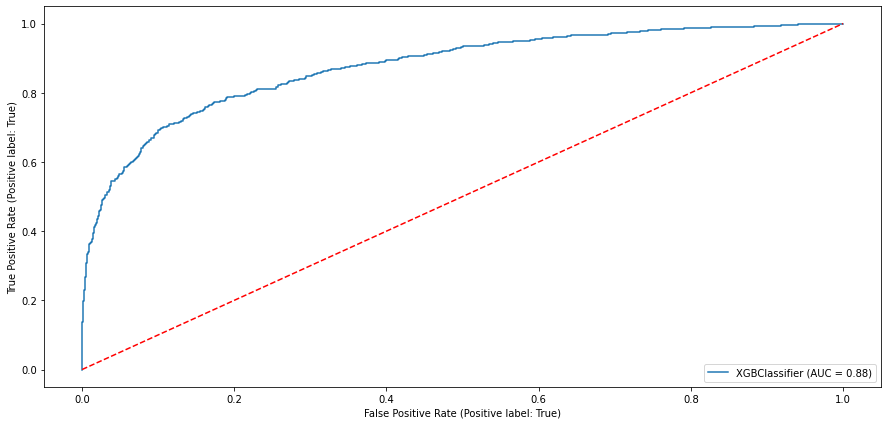

In [105]:
# graphical representation of model merformance: area under the ROC curve.
plt.rcParams["figure.figsize"] = (15,7)
import matplotlib.pyplot as plt 
metrics.plot_roc_curve(gs.best_estimator_, X_test, y_test) 
plt.plot([0, 1], [0, 1], "r--"); # set a random benchmark (red dotted line)

.

.

Try a different model: random forest.

In [91]:
# proceed with grid search; use random forest as estimator
from sklearn.ensemble import RandomForestClassifier

n = 10
estimator2 = RandomForestClassifier()
parameters2 = {'n_estimators': [100, 400, 10],
                'max_depth': [3, 15],
                'criterion': ["gini", "entropy"],}
gs2 = GridSearchCV(estimator=estimator2, param_grid=parameters2, scoring='accuracy', cv=n)
tune_results2 = gs2.fit(X_train, y_train.values.ravel())

#Get best hyperparameter results
gs2.best_params_

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 400}

In [123]:
# tuned model 
tuned_forest = RandomForestClassifier(n_estimators = 400, criterion = 'gini', max_depth = 3, random_state = 888)
model2 = tuned_forest.fit(X_train, y_train.values.ravel())

# make predictions on the test set
y_preds2 = model2.predict(X_test)

acc_score2 = metrics.accuracy_score(y_test.values, y_preds2) # accuracy score to check how accurate the model predicts classes 
auc_score2 = metrics.roc_auc_score(y_test, y_probs2) # area under the curve to check model performance
# both measures will be described in the final report 

In [124]:
acc_score2

0.8146666666666667

In [125]:
auc_score2

0.8367062383862688

In [126]:
# check performance measures for each of the 10 folds
perf_measures  = ['accuracy', 'roc_auc'] 
score = cross_validate(model2, X_test, y_test.values.ravel(), scoring=perf_measures, cv=n)
score

{'fit_time': array([0.98257184, 0.97568989, 0.94887018, 0.95085979, 0.94539094,
        0.95031738, 0.9569571 , 0.9490304 , 0.9467442 , 0.95297766]),
 'score_time': array([0.09450936, 0.09481525, 0.09302354, 0.09775782, 0.09583807,
        0.09404707, 0.09409285, 0.09667444, 0.09510756, 0.09615898]),
 'test_accuracy': array([0.81666667, 0.82      , 0.80666667, 0.82333333, 0.81666667,
        0.80333333, 0.83666667, 0.83      , 0.82666667, 0.81      ]),
 'test_roc_auc': array([0.85700732, 0.85307671, 0.76900409, 0.84897194, 0.87207823,
        0.80604112, 0.86792579, 0.8591521 , 0.82385641, 0.85379412])}

In [127]:
# average over every fold's performance measure
pd.DataFrame(score).mean()

fit_time         0.955941
score_time       0.095202
test_accuracy    0.819000
test_roc_auc     0.841091
dtype: float64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


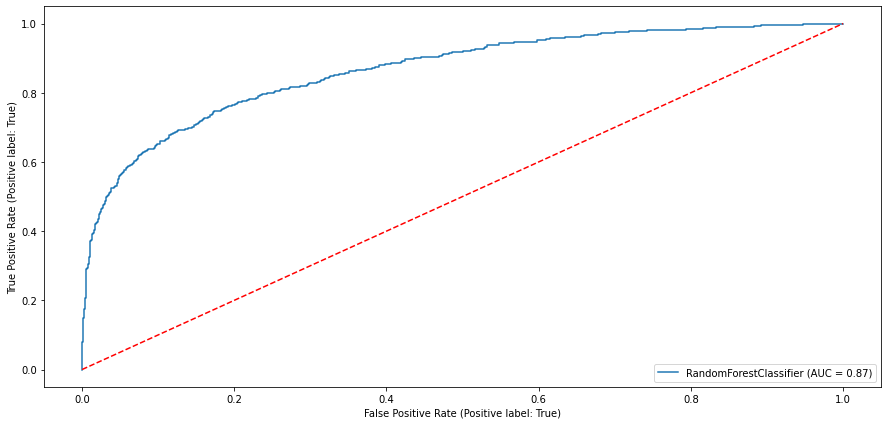

In [128]:
# graphical representation of model merformance: area under the ROC curve. 
import matplotlib.pyplot as plt 
metrics.plot_roc_curve(gs2.best_estimator_, X_test, y_test) 
plt.plot([0, 1], [0, 1], "r--");

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


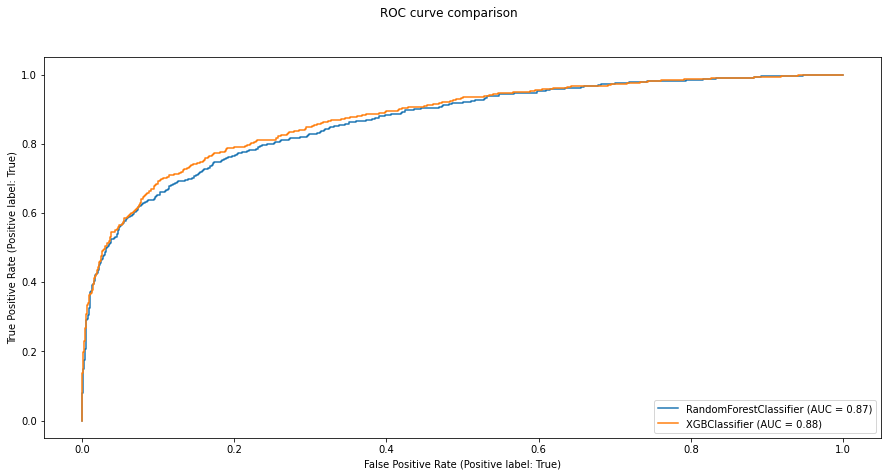

In [131]:
# compare two models in one graph 
from sklearn.metrics import plot_roc_curve
fig = plot_roc_curve(gs2.best_estimator_, X_test, y_test)
fig = plot_roc_curve(gs.best_estimator_, X_test, y_test, ax = fig.ax_)
fig.figure_.suptitle("ROC curve comparison")
plt.show()